<a target="_blank" href="https://colab.research.google.com/github/heechul/DeepPicar-v3/blob/devel/RunAll.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>

In [2]:
import tensorflow as tf

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import math
# from skimage import data
from skimage import io
from skimage.exposure import match_histograms
print(tf.__version__)


2.14.0


In [33]:

use_int8 = True  # use int8 input tensor
use_finetuning = False # use fine tuning after loading initial weights, instead of trainig from scratch

print("use_int8: ", use_int8)
print("use_finetuning: ", use_finetuning)

use_int8:  True
use_finetuning:  False


In [4]:
# input image resolution to the DNN model (smaller than the original dataset image resolution: 320x240x3)
img_width = 80
img_height = 60
img_channels = 3
temporal_context = 1  # number of past images to be used as input to the model
mode = "resize"  # "crop" or "resize
model_name = "opt-k2"
model_file = "models/{}-{}x{}x{}-T{}".format(model_name, img_width, img_height, img_channels, temporal_context)

print("model:", model_file)

model: models/opt-k2-80x60x3-T1


In [35]:
import requests 
import os
import zipfile

dataset_dir = "dataset"
dataset_zipfile = 'labtrack-leftonly-RTCSA22.zip' # 'Dataset-kucsl-Aug2022-zero.zip' # 'labtrack-leftonly-RTCSA22.zip' # 'Dataset.zip'
RunningInCOLAB = 'google.colab' in str(get_ipython())
force_unzip = False

if RunningInCOLAB: 
    print("in colab")
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
        dataset_zipfile = fn  # expecting a zip file to be uploaded. 
else:
    print ("not in colab")
    # RPI_IP=None # replace this with the IP address of your raspberry pi 
    # if RPI_IP is not None:
    #     URL="http://"+RPI_IP+":8000/"+dataset_zipfile
    #     filename=URL.split('/')[-1]
    #     r = requests.get(URL)
    #     open(filename, 'wb').write(r.content)

# if not os.path.isfile(dataset_zipfile):
#     default_dataset_URL = "https://raw.githubusercontent.com/heechul/DeepPicar-v3/devel/Dataset-kucsl-Apr2022.zip"    
#     print ("No existing dataset. download from ", default_dataset_URL)
#     r = requests.get(default_dataset_URL)
#     open(dataset_zipfile, 'wb').write(r.content)

if not os.path.isdir(dataset_dir) or force_unzip==True:
    print ('unzip %s into %s folder' % (dataset_zipfile, dataset_dir))
    zip_ref = zipfile.ZipFile(dataset_zipfile)
    zip_ref.extractall(dataset_dir)

not in colab


In [36]:
# Train/test data lists
imgs = []
vals = []

def rad2deg(rad):
    return 180.0 * rad / math.pi
def deg2rad(deg):
    return math.pi * deg / 180.0

# Scale the image to the model input size
def get_image_resize(img):
    orig_h, orig_w, orig_c = img.shape
    scaled_img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_NEAREST) 
                    # INTER_NEAREST (one implemented in the esp32-s3), 
                    # INTER_LINEAR, INTER_AREA (default), INTER_CUBIC, INTER_LANCZOS4

    # scale_x = int(orig_w / img_width)
    # scale_y = int(orig_h / img_height)

    # for i in range(img_height):
    #     for j in range(img_width):
    #         for k in range(orig_c):
    #             if scaled_img[i,j,k] != img[i*scale_y,j*scale_x,k]:
    #                 print("error", i, j, k, scaled_img[i,j,k], img[i*scale_y,j*scale_x,k])
    return scaled_img

# Crop the image to the model input size
def get_image_crop(img):
    orig_h, orig_w, _ = img.shape
    startx = int((orig_w - img_width) * 0.5); # crop from both sides
    starty = int((orig_h - img_height) * 0.75); # crop from bottom
    return img[starty:starty+img_height, startx:startx+img_width,:]

def preprocess(img):
    if mode == "crop":
        img = get_image_crop(img)
    elif mode == "resize":  
        img = get_image_resize(img)
    # Convert to grayscale and readd channel dimension
    if img_channels == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.reshape(img, (img_height, img_width, img_channels))
    if use_int8 == True:
        img = (img - 128).astype(np.int8)
    else:
        img = img.astype(np.float32) / 255.0
    return img

import glob
for vid_file_path in glob.iglob(f'{dataset_dir}/*.avi'):
    csv_file_path = vid_file_path.replace('video', 'key').replace('avi', 'csv')
    print(vid_file_path, csv_file_path)
    vid = cv2.VideoCapture(vid_file_path)
    df = read_csv(csv_file_path)

    # Read the video and steering angle data
    # keep 3 past images for temporal context
    temporal_context_buffer = []

    for val in df["wheel"].values:
        ret,img = vid.read()
        img = preprocess(img)

        # add temporal context to the input image
        temporal_context_buffer.append(img)
        if len(temporal_context_buffer) < temporal_context:
            for i in range(temporal_context - len(temporal_context_buffer)):
                temporal_context_buffer.append(img)
        elif len(temporal_context_buffer) > temporal_context:
            temporal_context_buffer.pop(0)   

        img = np.concatenate(temporal_context_buffer, axis=2)
        # print (img.shape)
        imgs.append(img)
        vals.append(val)
    print(len(imgs), len(vals))

# Convert lists to numpy arrays and ensure they are of equal length    
imgs = np.asarray(imgs)  # input images
vals = np.asarray(vals)  # steering angles
assert len(imgs) == len(vals)
print("Loaded {} smaples".format(len(imgs)))

dataset/out-video-t50-ittc-right-01.avi dataset/out-key-t50-ittc-right-01.csv
1000 1000
dataset/out-video-t50-ittc-right-00.avi dataset/out-key-t50-ittc-right-00.csv
2000 2000
dataset/out-video-t50-ittc-right-02.avi dataset/out-key-t50-ittc-right-02.csv
3000 3000
dataset/out-video-t50-ittc-right-03.avi dataset/out-key-t50-ittc-right-03.csv
4000 4000
dataset/out-video-t50-ittc-right-04.avi dataset/out-key-t50-ittc-right-04.csv
5000 5000
dataset/out-video-t50-ittc-right-05.avi dataset/out-key-t50-ittc-right-05.csv
6000 6000
dataset/out-video-t50-ittc-left-03.avi dataset/out-key-t50-ittc-left-03.csv
7000 7000
dataset/out-video-t50-ittc-left-02.avi dataset/out-key-t50-ittc-left-02.csv
8000 8000
dataset/out-video-t50-ittc-left-00.avi dataset/out-key-t50-ittc-left-00.csv
9000 9000
dataset/out-video-t50-ittc-left-01.avi dataset/out-key-t50-ittc-left-01.csv
10000 10000
dataset/out-video-t50-ittc-left-05.avi dataset/out-key-t50-ittc-left-05.csv
11000 11000
dataset/out-video-t50-ittc-left-04.avi

In [37]:
# Split the dataset for train and test 
print("Train/Test")
x_train, x_test, y_train, y_test = train_test_split(imgs, vals, test_size=0.25)

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
print("class_weights", class_weights)
class_weights = {i:class_weights[i] for i in range(len(class_weights))}
print("class_weights", class_weights)

Train/Test
class_weights [1.95439739 0.49817336 2.07900208]
class_weights {0: 1.9543973941368078, 1: 0.4981733643307871, 2: 2.079002079002079}


In [38]:
len(x_train)

9000

In [39]:
from keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds

model = tf.keras.Sequential()

l1_stride = 2
l2_stride = 2
l3_stride = 2
l1_kernel = (5,5)
l2_kernel = (5,5)
l3_kernel = (5,5)
l4_kernel = (3,3)
l5_kernel = (3,3)

if model_name == "opt-k2":
    if img_width == 160:
        l1_stride = 3
    elif img_width == 80:
        l5_kernel = (2,2)
    elif img_width == 40:
        l1_kernel = (3,3)
        l2_kernel = (3,3)
        l3_kernel = (2,2)
        l4_kernel = (2,2)
        l5_kernel = (2,2)
else:
    if img_width == 160:
        pass
    elif img_width == 80:
        l3_stride = 1
    elif img_width == 40:
        l2_stride = 1
        l3_stride = 1

model.add(layers.Conv2D(24, l1_kernel, strides=(l1_stride, l1_stride), activation='relu', input_shape=(img_height,img_width,img_channels*temporal_context)))
model.add(layers.Conv2D(36, l2_kernel, strides=(l2_stride, l2_stride), activation='relu'))
model.add(layers.Conv2D(48, l3_kernel, strides=(l3_stride, l3_stride), activation='relu'))
model.add(layers.Conv2D(64, l4_kernel, activation='relu'))
model.add(layers.Conv2D(64, l5_kernel, activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dropout(0.4))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, name="output", activation='tanh'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 14, 19, 24)        672       
                                                                 
 conv2d_11 (Conv2D)          (None, 6, 9, 36)          7812      
                                                                 
 conv2d_12 (Conv2D)          (None, 3, 4, 48)          6960      
                                                                 
 conv2d_13 (Conv2D)          (None, 2, 3, 64)          12352     
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 2, 64)          16448     
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dropout_8 (Dropout)         (None, 128)              

In [40]:
# a function to calculate MACs and FLOPs of the model
def calc_MAC_FLOPs(model):
    MACs = 0
    FLOPs = 0
    print ("layer name, output shape, MACs, FLOPs")
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D):
            _, Ho, Wo, Co = layer.output_shape # batch, height, width, channels
            Kh, Kw, Ci, _ = layer.kernel.shape # kernel height, kernel width, input channels, output channels
            mac = Ho * Wo * Co * Kh * Kw * Ci
            flop = 2 * mac
        elif isinstance(layer, layers.Dense):
            _, Co = layer.output_shape # batch, output channels
            Ci, _ = layer.kernel.shape # input channels, output channels
            mac = Ci * Co
            flop = 2 * mac
        elif isinstance(layer, layers.Flatten):
            mac = 0
            flop = 0
        elif isinstance(layer, layers.Dropout):
            # skip dropout layer
            continue
        else:
            raise Exception("unknown layer type")
        MACs += mac
        FLOPs += flop
        print(layer.name, layer.output_shape, mac, flop)

    return MACs, FLOPs

macs, _ = calc_MAC_FLOPs(model)
print("MACs: ", macs)

layer name, output shape, MACs, FLOPs
conv2d_10 (None, 14, 19, 24) 172368 344736
conv2d_11 (None, 6, 9, 36) 419904 839808
conv2d_12 (None, 3, 4, 48) 82944 165888
conv2d_13 (None, 2, 3, 64) 73728 147456
conv2d_14 (None, 1, 2, 64) 32768 65536
flatten_2 (None, 128) 0 0
dense_6 (None, 100) 12800 25600
dense_7 (None, 50) 5000 10000
dense_8 (None, 10) 500 1000
output (None, 1) 10 20
MACs:  800022


In [41]:
print("Quantize Model")
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

print ("Model compile")
q_aware_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(3e-4),
		                loss=tf.keras.losses.MeanSquaredError())
q_aware_model.summary()

Quantize Model
Model compile
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_2 (Quantize  (None, 30, 40, 3)         3         
 Layer)                                                          
                                                                 
 quant_conv2d_10 (QuantizeW  (None, 14, 19, 24)        723       
 rapperV2)                                                       
                                                                 
 quant_conv2d_11 (QuantizeW  (None, 6, 9, 36)          7887      
 rapperV2)                                                       
                                                                 
 quant_conv2d_12 (QuantizeW  (None, 3, 4, 48)          7059      
 rapperV2)                                                       
                                                                 
 quant_conv2d_13 (Quantiz

Model fit
Epoch 1/30
71/71 [==============================] - 2s 17ms/step - loss: 0.1132 - val_loss: 0.0840
Epoch 2/30
71/71 [==============================] - 1s 12ms/step - loss: 0.0881 - val_loss: 0.0757
Epoch 3/30
71/71 [==============================] - 1s 12ms/step - loss: 0.0807 - val_loss: 0.0666
Epoch 4/30
71/71 [==============================] - 1s 13ms/step - loss: 0.0761 - val_loss: 0.0609
Epoch 5/30
71/71 [==============================] - 1s 14ms/step - loss: 0.0704 - val_loss: 0.0585
Epoch 6/30
71/71 [==============================] - 1s 12ms/step - loss: 0.0685 - val_loss: 0.0564
Epoch 7/30
71/71 [==============================] - 1s 13ms/step - loss: 0.0638 - val_loss: 0.0556
Epoch 8/30
71/71 [==============================] - 1s 13ms/step - loss: 0.0631 - val_loss: 0.0514
Epoch 9/30
71/71 [==============================] - 1s 12ms/step - loss: 0.0617 - val_loss: 0.0521
Epoch 10/30
71/71 [==============================] - 1s 12ms/step - loss: 0.0585 - val_loss: 0.0553

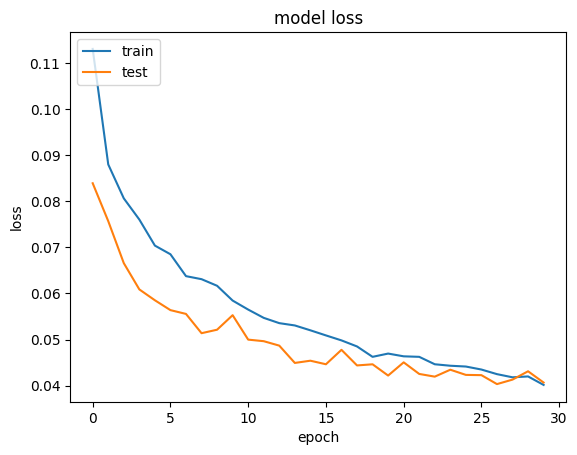

In [42]:
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# class_weights = {i:class_weights[i] for i in range(len(class_weights))}
# print("class_weights", class_weights)

if use_finetuning:
    q_aware_model.load_weights(model_file + ".h5")
    print("loaded weights from", model_file + ".h5")
    n_epochs = 5
else:
    n_epochs = 30

# Continue with the rest of the code
print ("Model fit")
# q_aware_model.reset_states()
history = q_aware_model.fit(x_train, y_train, batch_size=128,
                    epochs=n_epochs, validation_data=(x_test, y_test))

# Plot training and validation losses 
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

In [43]:
angle_thresh=10
# Helper functions for evaluating model accuracy

def get_action(angle_rad):
  degree = rad2deg(angle_rad)
  if degree < angle_thresh and degree > -angle_thresh:
    return "center"
  elif degree >= angle_thresh:
    return "right" 
  elif degree <-angle_thresh:
    return "left"

pred_angle = q_aware_model.predict(x_test)
pred = np.array(list(map(get_action, pred_angle)))
ground = np.array(list(map(get_action, y_test)))
print('Accuracy is %.3f' % np.mean(pred == ground))

94/94 [==============================] - 0s 2ms/step
Accuracy is 0.816


visualization

In [44]:
def plot_image(i, prediction_array, groundtrue_array, img_array):
  angle, predicted_label, groundtrue_label, img = int(rad2deg(pred_angle[i])), prediction_array[i], groundtrue_array[i], img_array[i]
  plt.grid(True)
  plt.xticks([])
  plt.yticks([])
  if use_int8 == True:
    img = np.round((img + 128.0) / 255.0, 2)
  else:
    img = np.squeeze(img)
  
  img_buffer = []
  for i in range(temporal_context):
    img_buffer.append(img[:,:,i*3:(i+1)*3])
  img = np.concatenate(img_buffer, axis=1)
  plt.imshow(img, cmap=plt.cm.binary)
  if predicted_label == groundtrue_label:
    color = 'green'
  else:
    color = 'red'  
  plt.xlabel("Predict:{} ({}) Actual:{}".format(predicted_label,angle,groundtrue_label), color=color)

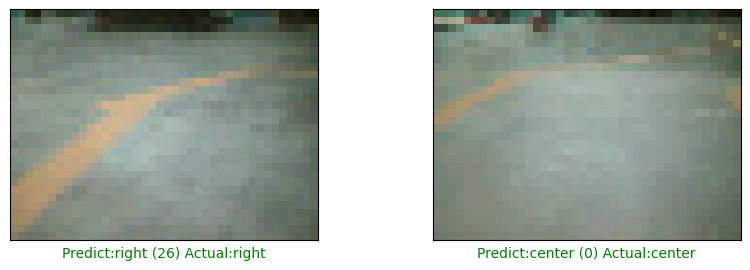

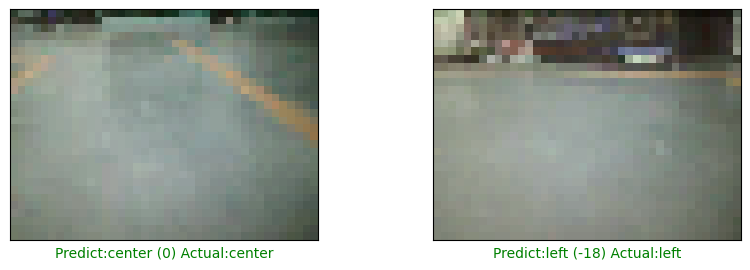

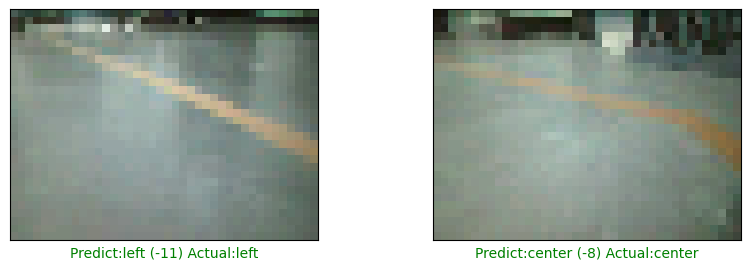

In [45]:
#@title Visualize the outputs { run: "auto" }
index = 1000 #@param {type:"slider", min:0, max:244, step:6}
for i in range(3):
  plt.figure(figsize=(10,3))
  plt.subplot(1,2,1)
  plot_image(index + 2*i, pred, ground, x_test)
  plt.subplot(1,2,2)
  plot_image(index + 2*i+1, pred, ground, x_test)
  plt.show()

generate image cpp files for testing

In [46]:
# Save both the Keras and TFLite models      
print("Model Save")                  
q_aware_model.save(model_file+".h5")

print("TFLite Model")
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

print("Using int8 quantization")

quantized_tflite_model = converter.convert()

with open(model_file+".tflite", 'wb') as f:
    f.write(quantized_tflite_model)

print (model_file+".tflite is saved. copy this file to the robot")

if RunningInCOLAB: 
    from google.colab import files
    files.download(model_file+".tflite")

Model Save
TFLite Model
Using int8 quantization


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpkhp084kj/assets


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpkhp084kj/assets
/opt/homebrew/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-01-12 11:01:49.322355: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-12 11:01:49.322370: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.


models/opt-k2-40x30x3-T1.tflite is saved. copy this file to the robot


2024-01-12 11:01:49.322583: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpkhp084kj
2024-01-12 11:01:49.326447: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-12 11:01:49.326462: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpkhp084kj
2024-01-12 11:01:49.337044: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-12 11:01:49.447383: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpkhp084kj
2024-01-12 11:01:49.480842: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 158258 microseconds.


generate cc file from tflite model

In [5]:
!xxd -n gmodel -i {model_file}.tflite > {model_file}.cc
print ("models/"+model_file+".cc --> src/model.h")
!cat {model_file}.cc | sed "s/unsigned/const unsigned/g" > src/model.h

models/models/opt-k2-80x60x3-T1.cc --> src/model.h


[-0.11377595]
Predicted: center (rad:[-0.11377595], deg:[-6.5188813])
Actual:  center


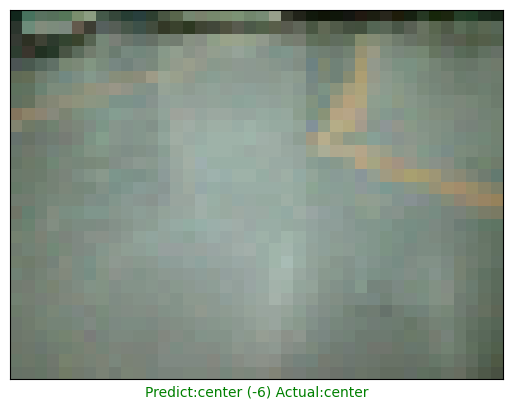

In [48]:
idx=100
img = x_test[idx]
# Write a C source file of the image for debugging purposes (to check if the model output is correct)
with open('src/img.h', 'w') as f:
    f.write('#ifndef IMG_TEST_DATA\n')
    f.write('#define IMG_TEST_DATA\n')
    f.write('const signed char img_data[] = {')
    for i in range(0, len(img.flatten())):
        f.write(str(img.flatten()[i]))
        if i < len(img.flatten()) - 1:
            f.write(',')    
    f.write('};\n')
    f.write('#endif\n')

plot_image(idx, pred, ground, x_test)
print(pred_angle[idx])
print("Predicted: {} (rad:{}, deg:{})".format(get_action(pred_angle[idx]), pred_angle[idx], rad2deg(pred_angle[idx])))
print("Actual: ", get_action(y_test[idx]))
plt.show()

### Inference

In [49]:
print("test img idx: {}, shape: {}".format(idx, img.shape))
print(img.flatten())

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
interpreter.set_tensor(input_index, np.expand_dims(img, axis=0))

input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

interpreter.invoke()
q = interpreter.get_tensor(output_index)[0][0]
scale = interpreter.get_output_details()[0]['quantization_parameters']['scales'][0]
zero_point = interpreter.get_output_details()[0]['quantization_parameters']['zero_points'][0]
print('scale, zero_point: ', scale, zero_point)
angle = (q - zero_point) * scale
print("Predicted: {} (q:{}, rad:{}, deg:{})".format(get_action(angle), q, angle, rad2deg(angle)))

test img idx: 100, shape: (30, 40, 3)
[-111  -91 -101 ...  -53  -46  -61]
input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>
scale, zero_point:  0.0078125 0
Predicted: center (q:-15, rad:-0.1171875, deg:-6.714349161689335)


In [50]:
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
scale = interpreter.get_output_details()[0]['quantization_parameters']['scales'][0]
zero_point = interpreter.get_output_details()[0]['quantization_parameters']['zero_points'][0]

pred_angle_q = []
for img in x_test:
    interpreter.set_tensor(input_index, np.expand_dims(img, axis=0))
    interpreter.invoke()
    q = interpreter.get_tensor(output_index)[0][0]
    angle = (q - zero_point) * scale
    pred_angle_q.append(angle)

pred_q = np.array(list(map(get_action, pred_angle_q)))
ground = np.array(list(map(get_action, y_test)))
print('Accuracy is %.3f' % np.mean(pred_q == ground))
print('float vs. quantized model same prediction prob: %.3f' % np.mean(pred_q == pred))

Accuracy is 0.818
float vs. quantized model same prediction prob: 0.997


In [51]:
print('Accuracy is %.3f' % np.mean(pred_q == ground))


Accuracy is 0.818
